In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,Sequential
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard,LambdaCallback
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import load_model
from QSAR_package.data_split import extractData,randomSpliter
from QSAR_package.feature_preprocess import correlationSelection
from QSAR_package.data_scale import dataScale
from QSAR_package.model_evaluation import modelEvaluator
from time import time
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss,roc_curve,auc
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
def Sec2Time(seconds):  # convert seconds to time
    m, s = divmod(int(seconds), 60)
    h, m = divmod(m, 60)
    return ("{:02d}h:{:02d}m:{:02d}s".format(h, m, s))

In [3]:
train_path = "C:/OneDrive/Jupyter_notebook/Deep_learning/spla2_som_train_312_maccs.csv"
test_path = "C:/OneDrive/Jupyter_notebook/Deep_learning/spla2_som_test_140_maccs.csv"
spliter = extractData()
spliter.ExtractTrainTestData(train_path, test_path, label_name='Activity')

tr_x = spliter.tr_x
tr_y = spliter.tr_y
te_y = spliter.te_y

# 压缩
scaler = dataScale(scale_range=(0.1, 0.9))
tr_scaled_x = scaler.FitTransform(tr_x)
te_scaled_x = scaler.Transform(spliter.te_x,DataSet='test')
print('train: {}\ntest: {}'.format(len(tr_scaled_x),len(te_scaled_x)))

train: 312
test: 140


In [4]:
tr_scaled_x.shape

(312, 166)

In [5]:
tr_y_OneHot = to_categorical(tr_y,num_classes=2)
te_y_OneHot = to_categorical(te_y,num_classes=2)

In [6]:
# 把原始训练集分成若干组小训练集和验证集
rs = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
rs.get_n_splits(tr_scaled_x,tr_y)
tr_idxs = []
va_idxs = []
for train_index, test_index in rs.split(tr_scaled_x,tr_y):
    tr_idxs.append(train_index)
    va_idxs.append(test_index)

In [7]:
len(tr_idxs)

5

In [11]:
tr_y_OneHot[tr_idxs[0]].shape

(249, 2)

In [8]:
# 自定义的回调函数——实时显示loss变化图
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, c='b',lw=1,label="loss")
        plt.plot(self.x, self.val_losses, c='r',lw=1,label="val_loss")
        plt.legend()
        plt.show();
        
    def on_train_end(self, logs={}):
        print('Training complete')       
plot_losses = PlotLosses()

In [9]:
# 构建网络结构
tf.keras.backend.clear_session()
t0 = time()

model = Sequential()
model.add(layers.Dense(units=64,activation='relu',input_shape=(tr_scaled_x.shape[1],)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=64,activation='relu',name='Layer2'))
model.add(layers.Dense(units=16,activation='relu'))
model.add(layers.Dense(units=8,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units=2,activation='sigmoid',name='OutputLayer'))

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005),
             loss='binary_crossentropy',metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=20, verbose=1,mode='auto',baseline=None)

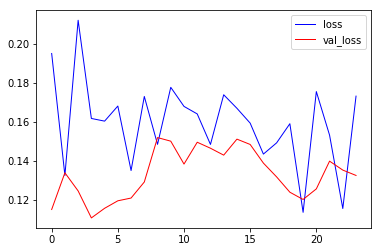

Training complete
Epoch 00024: early stopping
00h:00m:26s


In [10]:
# 训练模型（利用若干组小训练集和验证集重复训练与early_stop）
history = []
val_pred = []
val_y = []
for i in range(len(tr_idxs)):
    tr_x_input = tr_scaled_x.iloc[tr_idxs[i],:].values
    va_x_input = tr_scaled_x.iloc[va_idxs[i],:].values
    tr_y_input = tr_y_OneHot[tr_idxs[i]]
    va_y_input = tr_y_OneHot[va_idxs[i]]
    history.append(model.fit(x=tr_x_input,y=tr_y_input,epochs=2000,
                             validation_data=(va_x_input,va_y_input),batch_size=100,
                             verbose=0,callbacks=[plot_losses,early_stopping]))
    val_pred.extend(model.predict(x=va_x_input))
    val_y.extend(va_y_input)
    print(Sec2Time(time()-t0))

In [11]:
# 获取预测结果
tr_prob = model.predict(x=tr_scaled_x.values) #预测概率
te_prob = model.predict(x=te_scaled_x.values)
tr_pred = np.argmax(tr_prob,axis=1)  #预测概率转化成0和1
te_pred = np.argmax(te_prob,axis=1)

In [12]:
# 评价预测结果
te_Evaluator = modelEvaluator(te_y.values, te_pred)
val_Evaluator = modelEvaluator(np.argmax(val_y,axis=1), np.argmax(val_pred,axis=1))
tr_Evaluator = modelEvaluator(tr_y.values, tr_pred)
print(tr_Evaluator.mcc,tr_Evaluator.accuracy)
print(val_Evaluator.mcc,val_Evaluator.accuracy)
print(te_Evaluator.mcc,te_Evaluator.accuracy,te_Evaluator.se,te_Evaluator.sp)

0.94 0.9679
0.84 0.9206
0.8 0.8929 0.8395 0.9661


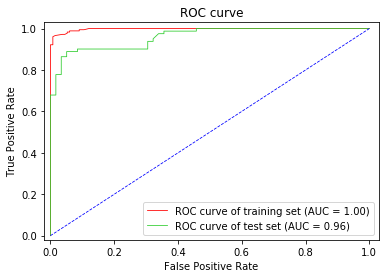

In [14]:
# 用预测的概率值画ROC曲线
tr_fpr,tr_tpr,tr_threshold = roc_curve(tr_y.values, tr_prob[:,1], pos_label=1, 
                                       drop_intermediate=True) ###计算真正率和假正率
tr_roc_auc = auc(tr_fpr,tr_tpr) ###计算auc的值 

te_fpr,te_tpr,te_threshold = roc_curve(te_y.values, te_prob[:,1], pos_label=1, 
                                       drop_intermediate=True) ###计算真正率和假正率
te_roc_auc = auc(te_fpr,te_tpr) ###计算auc的值

plt.figure()  
lw = 0.8  
# plt.figure(figsize=(6,6))
plt.plot(tr_fpr, tr_tpr, color='r',  
         lw=lw, label='ROC curve of training set (AUC = %0.2f)' % tr_roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(te_fpr, te_tpr, color='LimeGreen',  
         lw=lw, label='ROC curve of test set (AUC = %0.2f)' % te_roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='b', lw=lw, linestyle='--')  

plt.xlim([-0.02, 1.03])  
plt.ylim([-0.02, 1.03])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('ROC curve')  
plt.legend(loc="lower right")  
# plt.savefig('./cox-2/ROC_MLP_MLP_CORINA.tif',dpi=300,bbox_inches='tight')
plt.show()  

In [1561]:
# 保存模型
model.save('./cox-2/model_cox2_clf_MLP_MLP_CORINA.h5')

In [1563]:
# 保存预测结果（包括概率值）
result_df = pd.concat([pd.DataFrame(tr_prob,columns=['tr_prob0','tr_prob1']),
                     pd.DataFrame(val_pred,columns=['val_prob0','val_prob1']),
                     pd.DataFrame(te_prob,columns=['te_prob0','te_prob1'])],axis=1)
result_df.to_csv('./cox-2/pred_results_MLP_MLP_CORINA.csv',index=False)

In [15]:
# 从history获取每个epoch的loss值

tr_loss = []
va_loss = []
tr_loss_flat = []
va_loss_flat = []
# tr_acc_flat = []
# va_acc_flat = []
for i in range(len(history)):
    tr_loss.append(history[i].history['loss'])
    va_loss.append(history[i].history['val_loss'])
    tr_loss_flat.extend(history[i].history['loss'])
    va_loss_flat.extend(history[i].history['val_loss'])
#     tr_loss_flat.extend(history[i].history['acc'])
#     va_loss_flat.extend(history[i].history['val_acc'])

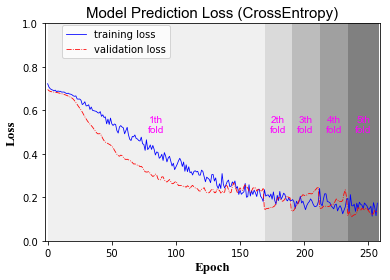

In [16]:
# 绘制所有训练过程的loss变化图
step = 0
flag = [0]
for i in range(len(tr_loss)-1):
    step = step+len(tr_loss[i])
    flag.append(step)
flag.append(len(tr_loss_flat))

h = 0.05
x_min = 0
x_max = len(tr_loss_flat)
y_min = min(tr_loss_flat)-1
y_max = max(tr_loss_flat)+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = np.zeros_like(xx)

for i in range(len(flag)-1):
    Z[np.where((flag[i]<xx)&(xx<=flag[i+1]))] = i+1

fig = plt.figure()
plt.plot(tr_loss_flat,c='b',ls='solid',lw=0.8)
plt.plot(va_loss_flat,c='r',ls='-.',lw=0.8)
plt.imshow(Z, interpolation='nearest',alpha=0.5,
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Greys,
           aspect='auto', origin='lower')
plt.title('Model Prediction Loss (CrossEntropy)',fontproperties='Arial',
          fontsize=15,fontstyle='normal')
plt.xlim(-2,x_max+1)
plt.ylim(0,1)
for i in range(len(flag)-1):
    plt.text(np.average(flag[i:i+2]), 0.5, '{}th\nfold'.format(i+1), fontsize=2,color='#FF00FF',
             fontproperties='Arial',rasterized=True,horizontalalignment='center')
plt.ylabel('Loss',fontproperties='Times New Roman',fontsize=13)
plt.xlabel('Epoch',fontproperties='Times New Roman',fontsize=13)
plt.legend(['training loss', 'validation loss'], loc=(0.05,0.84))
# plt.savefig('./cox-2/loss_fig_MLP_MLP_CORINA.tif',dpi=300,bbox_inches='tight')
plt.show()

In [1544]:
#==============保存loss值文件============#

tr_loss_df = pd.DataFrame(tr_loss,index=['fold_{}'.format(i+1) for i in range(len(tr_loss))]).T
val_loss_df = pd.DataFrame(va_loss,index=['fold_{}'.format(i+1) for i in range(len(va_loss))]).T

tr_loss_df.to_csv('./cox-2/tr_loss_MLP_MLP_CORINA.csv',index=False)
val_loss_df.to_csv('./cox-2/val_loss_MLP_MLP_CORINA.csv',index=False)

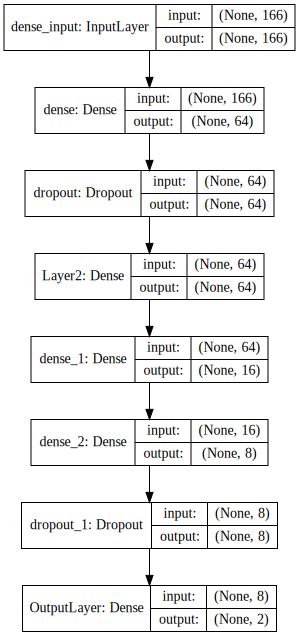

In [17]:
# 生成神经网络结构图

# plot_model(model,to_file='./cox-2/model_MLP_MLP_CORINA.tif',show_shapes=True,rankdir='TB')
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))